<a href="https://colab.research.google.com/github/ygmurkara/DI501/blob/main/DI_501_Lab_2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 501 - Introduction to Data Informatics
### Regression

In this lab session we will quickly glance over utilities in scikit-learn and other libraries to aid regression tasks.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import statsmodels.api as sm

In this first part we will go back to qs university rankings. For reference the below code blocks were executed to preprocess the data, but you can skip this part by importing the preprocessed file.

In [ ]:
data = pd.read_csv('2024 QS World University Rankings 1.1 (For qs.com).csv', sep=';', skiprows=3)
data.head(3)

,rank display,rank display2,institution,location code,location,size,focus,research,age band,status,...,ifr rank,isr score,isr rank,irn score,irn rank,ger score,ger rank,SUS SCORE,SUS RANK,Overall Score
0,1,1,Massachusetts Institute of Technology (MIT),US,United States,M,CO,VH,5.0,B,...,56,88.2,128,94.3,58,100.0,4,95.2,51,100.0
1,2,2,University of Cambridge,UK,United Kingdom,L,FC,VH,5.0,A,...,64,95.8,85,99.9,7,100.0,6,97.3,33=,99.2
2,3,4,University of Oxford,UK,United Kingdom,L,FC,VH,5.0,A,...,110,98.2,60,100.0,1,100.0,3,97.8,26=,98.9


In [ ]:
data.columns = [x.lower().replace(' ', '_') for x in data.columns]

rank_cols = {x for x in data.columns if x.endswith('rank')}

simplified = data.iloc[:,~data.columns.isin(rank_cols)]

simplified.loc[:,'rank_display'] = simplified['rank_display'].str.extract('=?(\d*)').values
simplified.loc[:,'rank_display2'] = simplified['rank_display2'].str.extract('=?(\d*)').values

simplified.rank_display = simplified.rank_display.astype('int')
simplified.rank_display2 = simplified.rank_display2.astype('float')

simplified.overall_score = simplified['overall_score'].replace('-', np.NaN).astype(float)

simplified.loc[:,'age_band'] = simplified['age_band'].astype('object').values

import pycountry
from pycountry_convert import country_alpha2_to_continent_code

simplified.loc[:, 'location_code'] = simplified['location_code'].replace('UK', 'GB')

simplified.loc[:,'continent'] = simplified['location_code'].apply(country_alpha2_to_continent_code)

/var/folders/5p/rbnmtvhx5437fb_9sp9b1ln80000gn/T/ipykernel_33566/4181190625.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified.rank_display = simplified.rank_display.astype('int')
/var/folders/5p/rbnmtvhx5437fb_9sp9b1ln80000gn/T/ipykernel_33566/4181190625.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified.rank_display2 = simplified.rank_display2.astype('float')
/var/folders/5p/rbnmtvhx5437fb_9sp9b1ln80000gn/T/ipykernel_33566/4181190625.py:13: SettingWithCopyWarning: 
A value is try

In [ ]:
simplified.to_csv('2024 QS Processed.csv', index=False)

Recall that calculating separate correlations for each score did not match the percentages reported by qs for overall score. To test the effect of a combination of variables multivariate regression can be utilized. As an exercise, let's first only use the score values to see if we can recover the weights ourselves.

In [ ]:
qs = pd.read_csv('2024 QS Processed.csv',
                keep_default_na=False, na_values='') # Avoid reading NA for north america as NaN

qs.head()

,rank_display,rank_display2,institution,location_code,location,size,focus,research,age_band,status,...,er_score,fsr_score,cpf_score,ifr_score,isr_score,irn_score,ger_score,sus_score,overall_score,continent
0,1,1.0,Massachusetts Institute of Technology (MIT),US,United States,M,CO,VH,5.0,B,...,100.0,100.0,100.0,100.0,88.2,94.3,100.0,95.2,100.0,NA
1,2,2.0,University of Cambridge,GB,United Kingdom,L,FC,VH,5.0,A,...,100.0,100.0,92.3,100.0,95.8,99.9,100.0,97.3,99.2,EU
2,3,4.0,University of Oxford,GB,United Kingdom,L,FC,VH,5.0,A,...,100.0,100.0,90.6,98.2,98.2,100.0,100.0,97.8,98.9,EU
3,4,5.0,Harvard University,US,United States,L,FC,VH,5.0,B,...,100.0,98.3,100.0,84.6,66.8,100.0,100.0,96.7,98.3,NA
4,5,3.0,Stanford University,US,United States,L,FC,VH,5.0,B,...,100.0,100.0,99.9,99.9,51.2,95.8,100.0,94.4,98.1,NA


[missingno](https://github.com/ResidentMario/missingno) is a useful package when analyzing number and distribution of missing values in a dataset.

`msno.bar()` creates a bar chart that shows the completeness of each column.

* The height of the bar shows the number of non-missing values.

<Axes: >

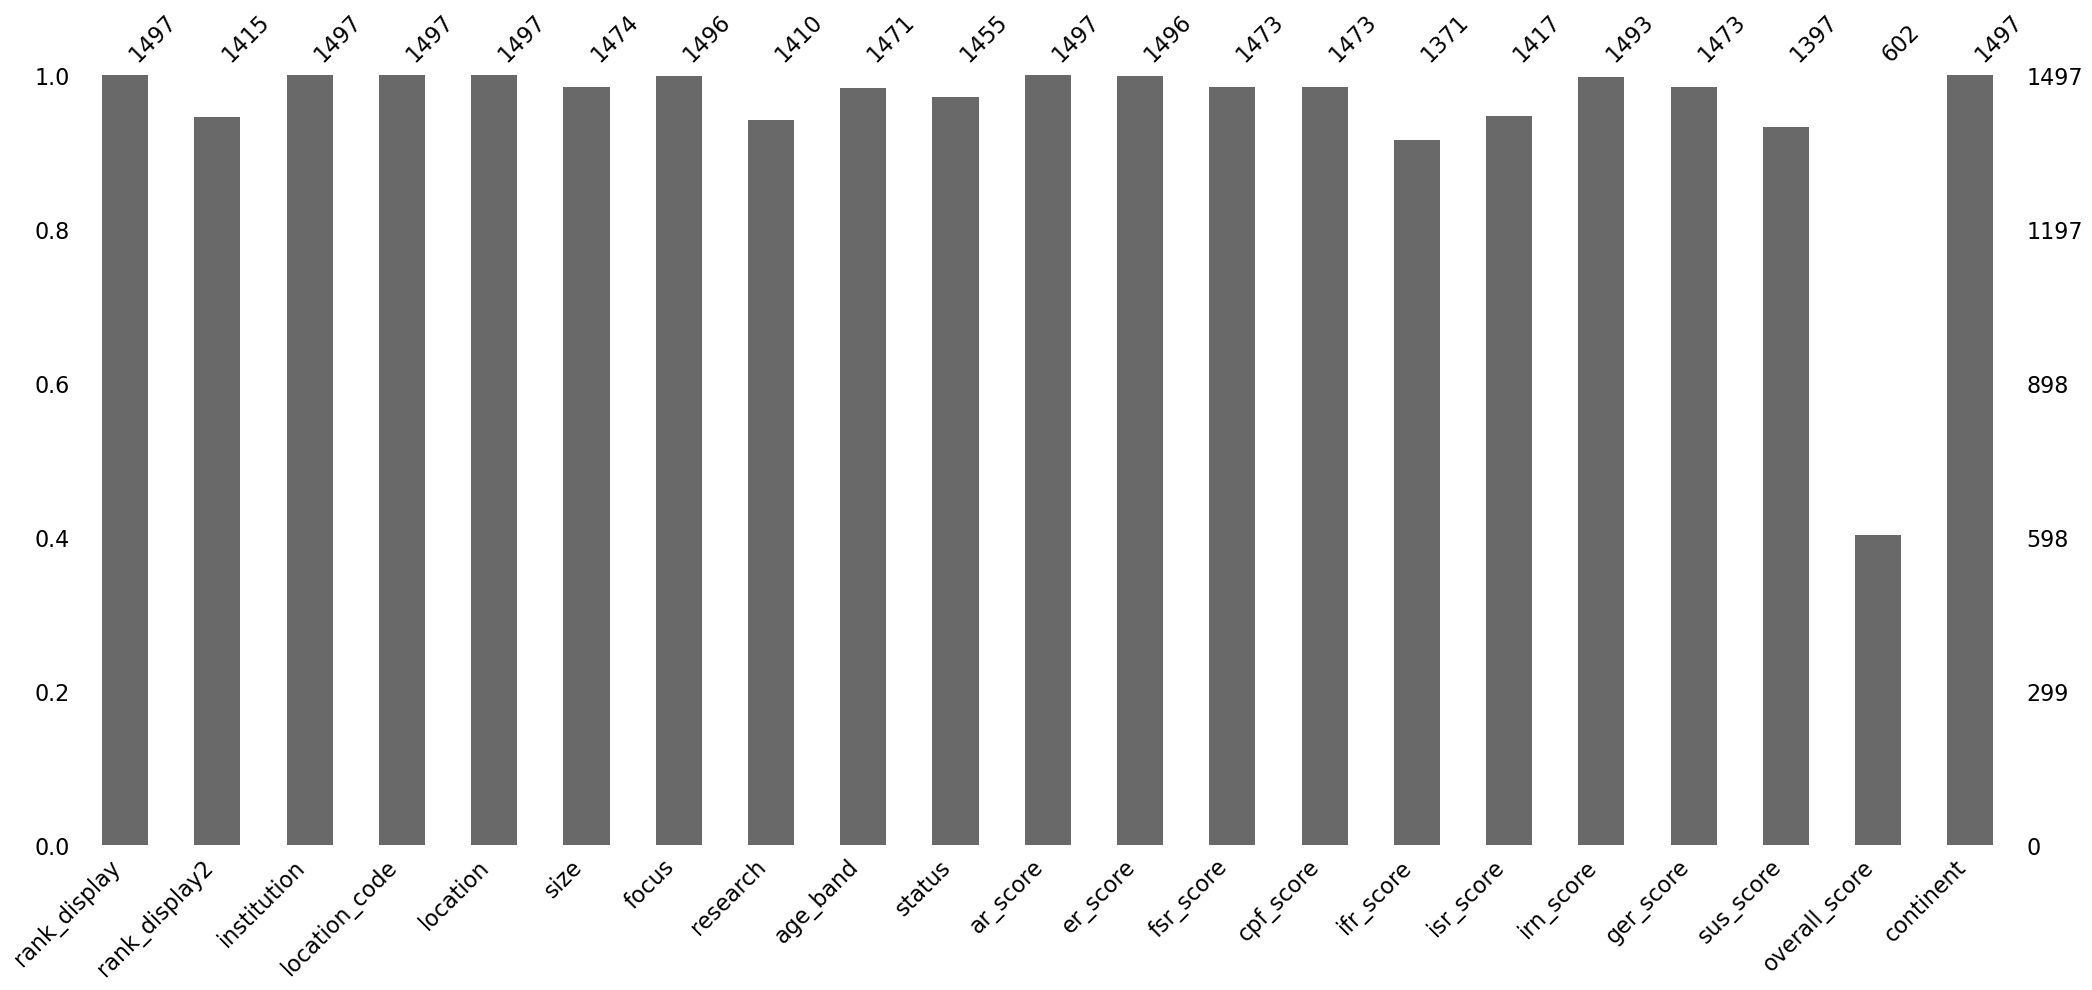

In [ ]:
#!pip install missingno
import missingno as msno

msno.bar(qs)

`msno.matrix()` function provides a matrix visualization of missing data. It helps detect missing data patterns
and correlations between missingness.

<Axes: >

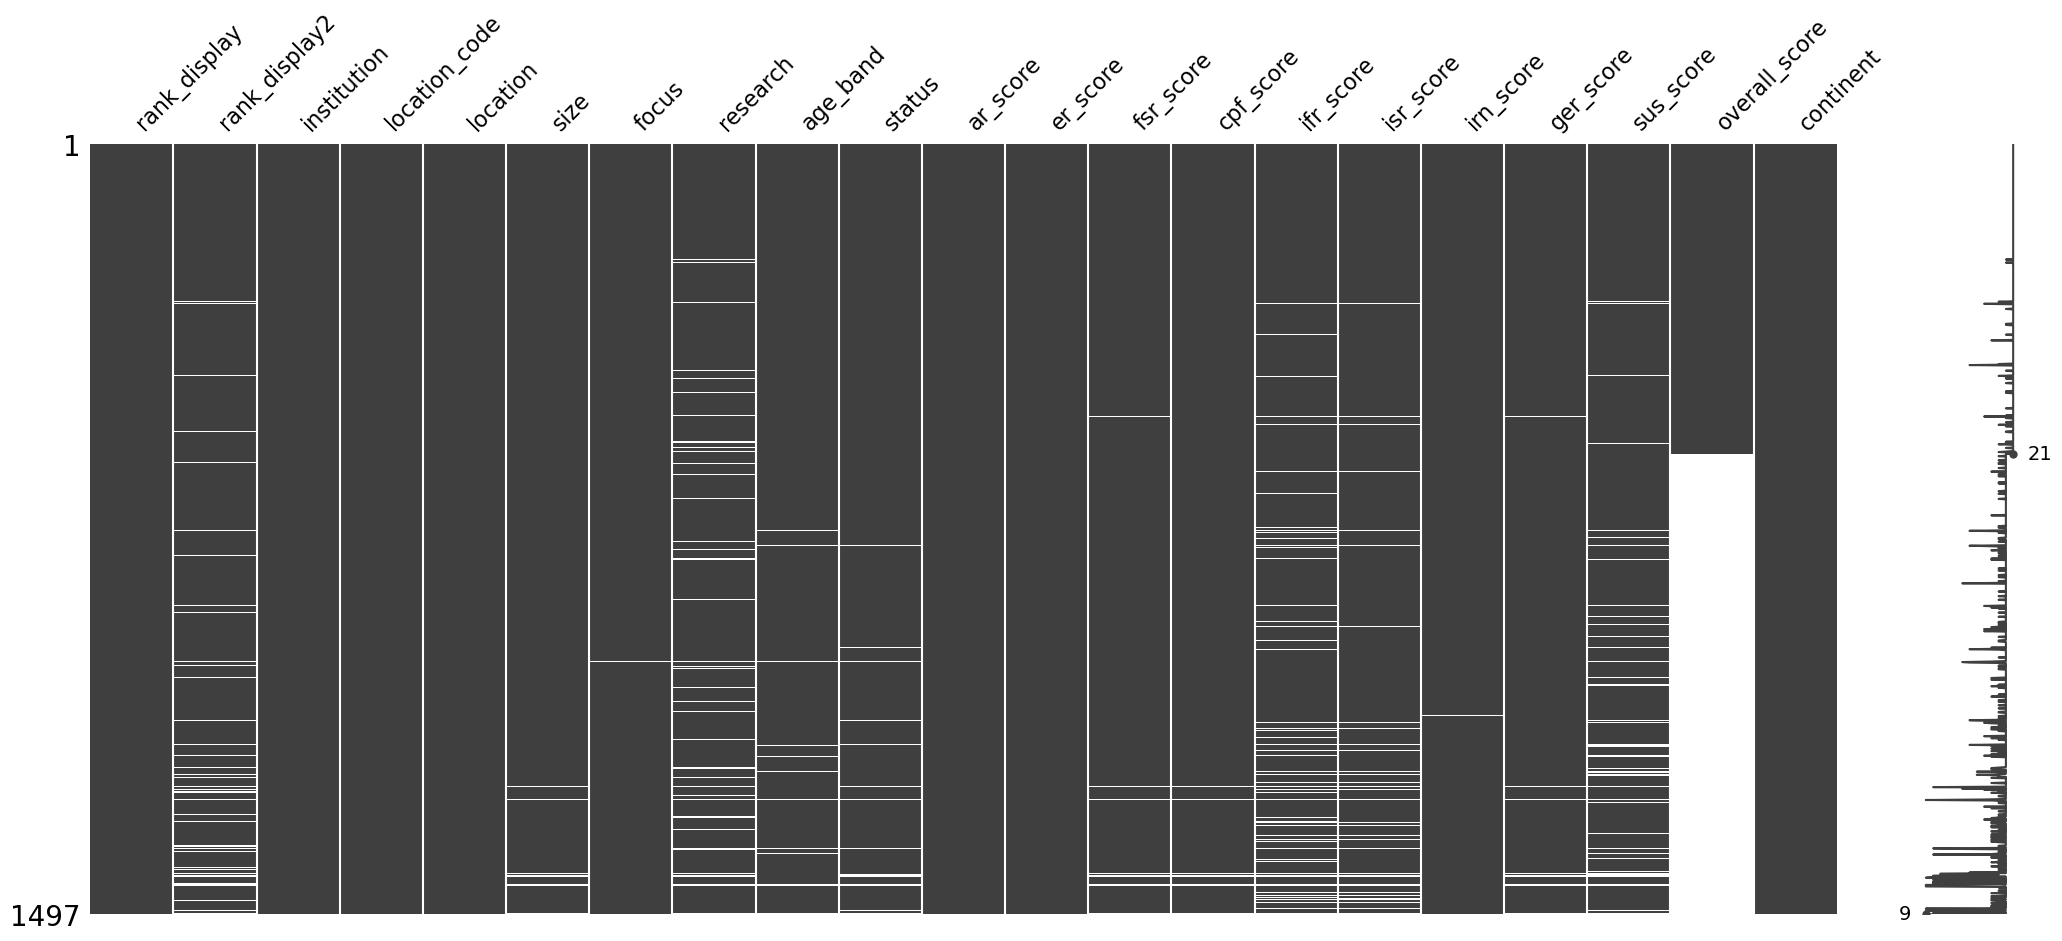

In [ ]:
msno.matrix(qs)

`msno.heatmap()` shows how missing values are correlated across columns. Each cell shows a correlation between the missingness of two columns (using nullity correlation).

<Axes: >

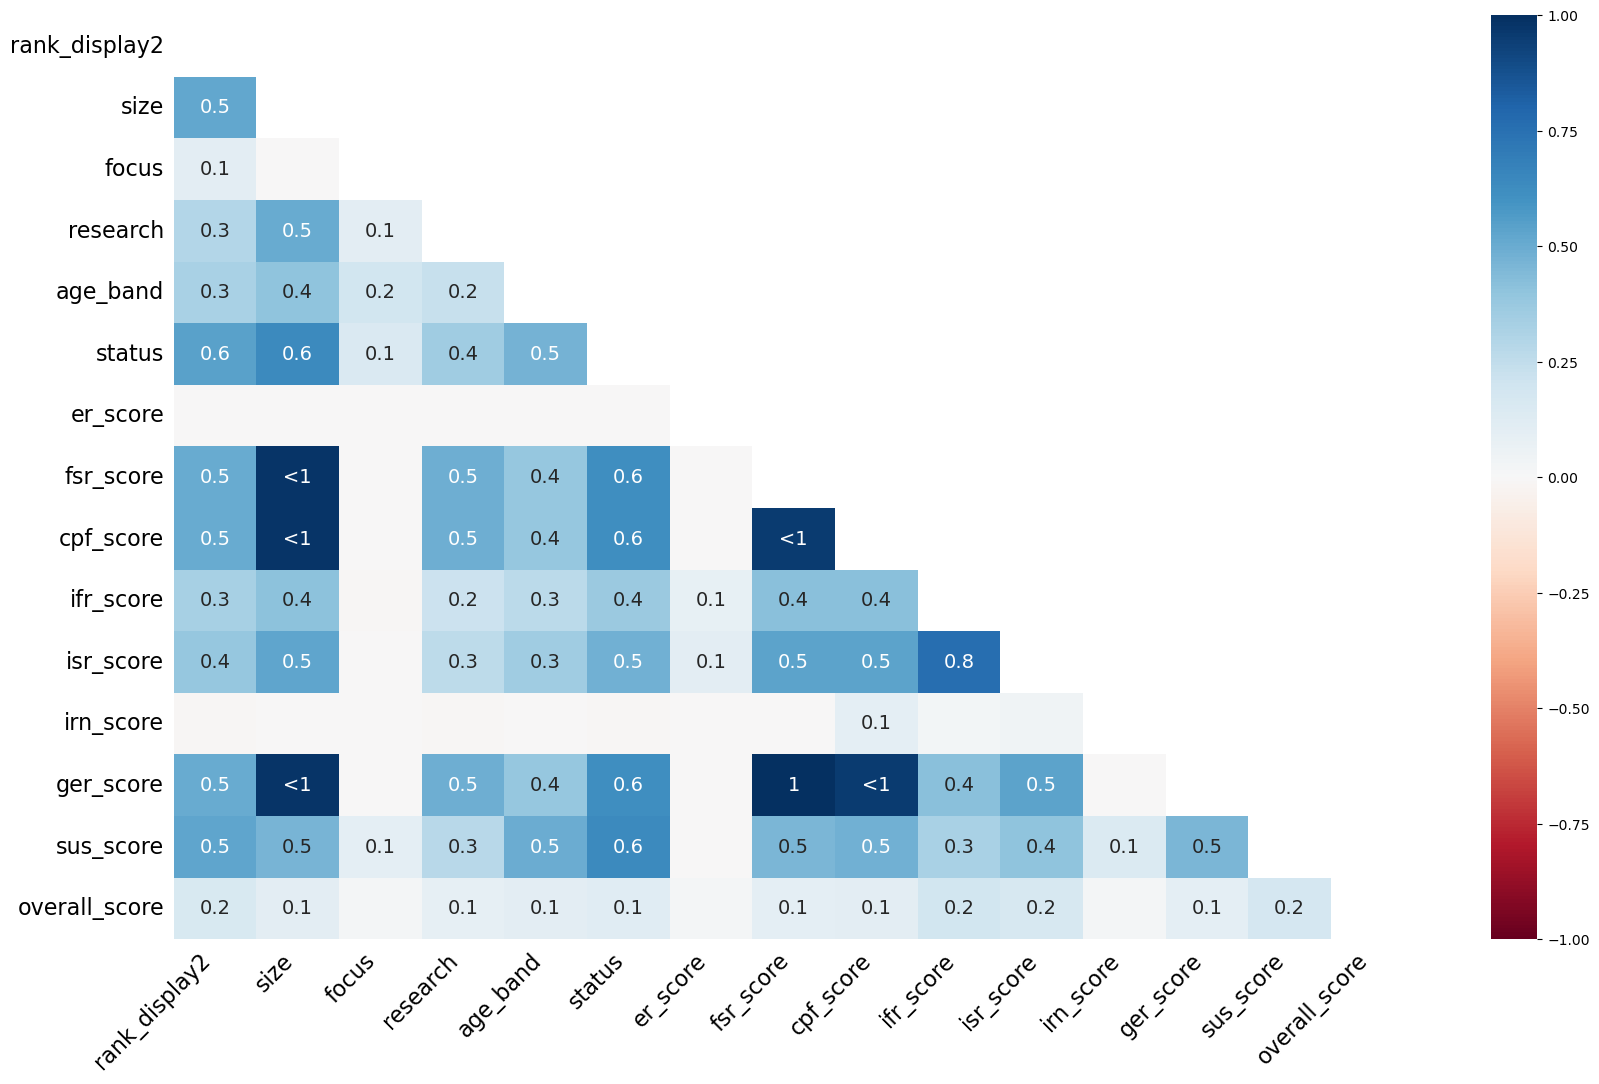

In [ ]:
msno.heatmap(qs)

Let's only focus on scores, and drop rows with any missing values (including overall_score).

In [ ]:
num_cols = [col for col,dtype in zip(qs.columns, qs.dtypes) if dtype!='object'][3:]

simple = qs[num_cols].dropna()

X = simple[num_cols[:-1]]
y = simple[num_cols[-1]]  # this is the target = overall_score

- We use Ordinary Least Squares (OLS) regression to examine how different performance metrics contribute to a university’s overall QS score.

- `summary()` provides detailed statistics — including coefficients, p-values, and R-squared — to help us interpret the contribution and significance of each feature.

In [ ]:
lr = sm.OLS(y, X).fit()
print(lr.summary())

                                 OLS Regression Results                                
Dep. Variable:          overall_score   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.103e+06
Date:                Mon, 07 Apr 2025   Prob (F-statistic):                        0.00
Time:                        23:12:10   Log-Likelihood:                          237.13
No. Observations:                 586   AIC:                                     -456.3
Df Residuals:                     577   BIC:                                     -416.9
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Question 1
Based on the regression summary table, what can you infer about the contribution of each feature to the overall QS score and their statistical significance? Explain your reasons.

> Fill here by double clicking me!

In fact these are the same as our original [percentages](https://support.qs.com/hc/en-gb/articles/4405955370898-QS-World-University-Rankings):

### Weights for overall rank

| Performances Lenses            | Weights  |
|--------------------------------|-----------------------|
| Academic Reputation            | 30%                   |
| Employer Reputation            | 15%                   |
| Faculty Student Ratio          | 10%                   |
| Citations per Faculty          | 20%                   |
| International Faculty Ratio    | 5%                    |
| International Student Ratio    | 5%                    |
| International Research Network | 5%                    |
| Employment Outcomes            | 5%                    |
| Sustainability                 | 5%                    |

Which is made even more evident by the following calculation.

This plot compares:

* Our reconstructed scores i.e. weighted sum of the components (x-axis) and
* The actual overall_score column from the dataset (y-axis)

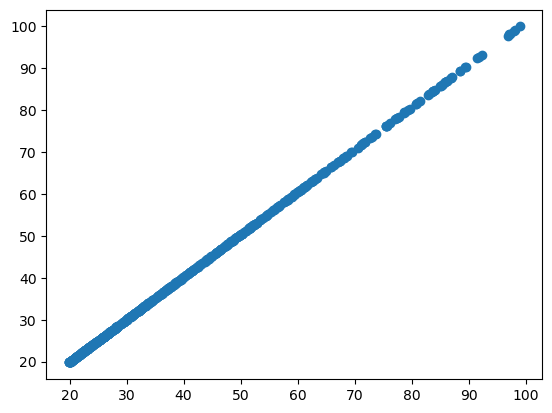

In [ ]:
perc = pd.Series([0.3,0.15,0.1,0.2,0.05,0.05,0.05,0.05,0.05], index=num_cols[:-1])

plt.scatter(np.sum(qs[num_cols] * perc, axis=1), qs.overall_score)

The points lie almost perfectly on a diagonal line, meaning the reconstructed scores are almost exactly the same as the original ones.
This confirms that QS really does use these weights to calculate the overall_score.

Let's then fill in the missing overall scores by multiplying the existing feature values from qs[num_cols[:-1]] with the corresponding weights (perc), and summing them up (if the values exist).


In [ ]:
updated = qs.overall_score.fillna(np.sum(qs[num_cols[:-1]].dropna()*perc, axis=1))

updated

0       100.000
1        99.200
2        98.900
3        98.300
4        98.100
         ...   
1492      3.425
1493        NaN
1494      4.035
1495        NaN
1496        NaN
Name: overall_score, Length: 1497, dtype: float64

In [ ]:
qs.loc[:,'overall_score'] = updated

The missing values in the overall_score column are now filled with the calculated values based on the weighted sum of the features.

## Effect of additional features

Recall the definition of our categorical variables. Since the categories have an inherent order, it is crucial to encode them with integer values that reflect this ordering. This is different from one-hot encoding, where categories are represented by binary variables without considering their natural order. By using integers, we preserve the order information, which is valuable for models that can utilize this hierarchy.

<table>

<td>

|    | Size        | Students         |
|----|-------------|------------------|
| XL | Extra Large | >=30,000 |
| L  | Large       | >=12,000         |
| M  | Medium      | >=5,000          |
| S  | Small       | <5,000 |

</td>
<td>

|    | Focus              | Faculty Area                         |
|----|--------------------|--------------------------------------|
| FC | Full comprehensive | All 5 faculty areas + medical school |
| CO | Comprehensive      | All 5 faculty areas                  |
| FO | Focused            | 3 or 4 faculty areas                 |
| SP | Specialist         | 2 or fewer faculty areas             |

</td>
<td>

|   | Classification | Age                    |
|---|----------------|------------------------|
| 5 | Historic       | >=100 years old        |
| 4 | Mature         | 50-99 years old        |
| 3 | Established    | 25-49 years old        |
| 2 | Young          | 10-24 years old        |
| 1 | New            | < 10 years old |

</td>
<td>

|    | Research Intensity |
|----|--------------------|
| VH | Very High          |
| HI | High               |
| MD | Medium             |
| LO | Low                |

</td>
</table>

In [ ]:
qs['size'].unique()

array(['M', 'L', 'XL', 'S', nan], dtype=object)

In [ ]:
qs['research'].unique()

array(['VH', 'HI', nan, 'MD', 'LO'], dtype=object)

In [ ]:
qs['focus'].unique()

array(['CO', 'FC', 'FO', 'SP', nan], dtype=object)

In [ ]:
qs['status'].unique()

array(['B', 'A', 'C', nan], dtype=object)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

qs_na = qs.dropna()

size_enc = OrdinalEncoder(categories=[['S', 'M', 'L', 'XL']])

qs_na.loc[:,'size'] = size_enc.fit_transform(qs_na['size'].values.reshape(-1,1))  # the encoder expects the data to be in a 2D shape (n_samples, n_features).

In [ ]:
res_enc = OrdinalEncoder(categories=[['LO', 'MD', 'HI', 'VH']])

qs_na.loc[:,'research'] = res_enc.fit_transform(qs_na.research.values.reshape(-1,1))

In [ ]:
focus_enc = OrdinalEncoder(categories=[['SP', 'FO', 'CO', 'FC']])

qs_na.loc[:,'focus'] = focus_enc.fit_transform(qs_na.focus.values.reshape(-1,1))

In [ ]:
qs_na = qs_na.astype({'rank_display':float,
                      'size':int,
                      'research':int,
                      'focus':int,
                      'age_band':int})

In [ ]:
qs_na.location_code.value_counts()

location_code
US    173
GB     89
CN     58
JP     45
RU     43
     ... 
QA      1
BG      1
CY      1
BY      1
SD      1
Name: count, Length: 94, dtype: int64

## Question 2

For the continent column, apply appropriate encoder and explain your reasoning.

In [ ]:
# fill here #

> Fill here by double clicking me!

In [ ]:
qs_na.head()

,rank_display,rank_display2,institution,location_code,location,size,focus,research,age_band,status,...,irn_score,ger_score,sus_score,overall_score,continent_AF,continent_AS,continent_EU,continent_NA,continent_OC,continent_SA
0,1.0,1.0,Massachusetts Institute of Technology (MIT),US,United States,1,2,3,5,B,...,94.3,100.0,95.2,100.0,False,False,False,True,False,False
1,2.0,2.0,University of Cambridge,GB,United Kingdom,2,3,3,5,A,...,99.9,100.0,97.3,99.2,False,False,True,False,False,False
2,3.0,4.0,University of Oxford,GB,United Kingdom,2,3,3,5,A,...,100.0,100.0,97.8,98.9,False,False,True,False,False,False
3,4.0,5.0,Harvard University,US,United States,2,3,3,5,B,...,100.0,100.0,96.7,98.3,False,False,False,True,False,False
4,5.0,3.0,Stanford University,US,United States,2,3,3,5,B,...,95.8,100.0,94.4,98.1,False,False,False,True,False,False


In [ ]:
qs_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1229 entries, 0 to 1494
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank_display   1229 non-null   float64
 1   rank_display2  1229 non-null   float64
 2   institution    1229 non-null   object 
 3   location_code  1229 non-null   object 
 4   location       1229 non-null   object 
 5   size           1229 non-null   int64  
 6   focus          1229 non-null   int64  
 7   research       1229 non-null   int64  
 8   age_band       1229 non-null   int64  
 9   status         1229 non-null   object 
 10  ar_score       1229 non-null   float64
 11  er_score       1229 non-null   float64
 12  fsr_score      1229 non-null   float64
 13  cpf_score      1229 non-null   float64
 14  ifr_score      1229 non-null   float64
 15  isr_score      1229 non-null   float64
 16  irn_score      1229 non-null   float64
 17  ger_score      1229 non-null   float64
 18  sus_score    

In [ ]:
cat = [col for col,dtype in zip(qs_na.columns, qs_na.dtypes) if dtype not in ['object','float64']]

In [ ]:
new_X = sm.add_constant(qs_na[cat])
# new_X = sm.add_constant(qs_na[cat + num_cols[:-1]])

In [ ]:
y = qs_na['overall_score']

model2 = sm.OLS(y, new_X.astype(int)).fit()

In [ ]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          overall_score   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     68.29
Date:                Mon, 07 Apr 2025   Prob (F-statistic):          9.21e-102
Time:                        23:12:10   Log-Likelihood:                -5201.9
No. Observations:                1229   AIC:                         1.042e+04
Df Residuals:                    1219   BIC:                         1.047e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -35.1437      2.825    -12.439   

## Another case

This time we will focus on a dataset of solar panel generation and many weather related columns. Since we are not given any column information, we don't know whether it makes sense to include all of them. Let's see what we can find when going in blind.

In [ ]:
pvm = pd.read_csv('pv_data.csv',index_col=0)

In [ ]:
pvm.head()

,U2M,V250,TROPT,TROPPB,T2M,TQL,T500,TOX,U850,PS,...,QV10M,LWGAB,SWLAND,PRECLSCORR,PRECCUCORR,PARDF,SWGDN,PRECSNOCORR,PARDR,generation_mw
2023-07-01 00:30:00+00:00,3.327844,-5.805844,216.74097,22642.006,289.18585,0.056580,262.92240,0.006956,11.825224,99506.375,...,0.010958,356.78640,0.000000,0.000009,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000
2023-07-01 01:30:00+00:00,3.342380,-3.687345,217.28345,22640.912,289.10156,0.066910,262.53152,0.006989,11.602690,99449.790,...,0.010891,362.62750,0.000000,0.000010,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000
2023-07-01 02:30:00+00:00,3.328679,-8.294871,219.20236,22640.520,288.96063,0.064224,262.60430,0.007075,11.525191,99417.880,...,0.010809,359.93237,0.000000,0.000010,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000
2023-07-01 03:30:00+00:00,3.249641,-17.971140,219.84341,22640.268,288.69244,0.082779,262.71985,0.007095,11.408081,99412.750,...,0.010691,352.54960,0.222715,0.000010,0.0,0.088955,0.279740,0.0,3.613666e-08,0.000000
2023-07-01 04:30:00+00:00,3.387968,-24.947979,220.24130,22641.637,288.70657,0.111969,262.56800,0.007049,10.805376,99430.125,...,0.010579,356.35510,20.794027,0.000008,0.0,9.155069,27.317741,0.0,1.576914e+00,1.152103


In [ ]:
pvm.shape

(1512, 56)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [ ]:
X, y = pvm.iloc[:,:-1], pvm.generation_mw

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

lr_pipe = make_pipeline(StandardScaler(), LinearRegression()) # creates a pipeline with standard scaling (to normalize the features) and linear regression
print(lr_pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])


In [ ]:
lr_pipe.fit(X_train, y_train)

y_pred_train = lr_pipe.predict(X_train)
y_pred_val = lr_pipe.predict(X_val)
y_pred_test = lr_pipe.predict(X_test)

print(f'RMSE (Train) for Linear Regression: {mean_squared_error(y_pred_train, y_train)**0.5:.3f}')
print(f'RMSE (Val) for Linear Regression: {mean_squared_error(y_pred_val, y_val)**0.5:.3f}')
print(f'RMSE (Test) for Linear Regression: {mean_squared_error(y_pred_test, y_test)**0.5:.3f}')

RMSE (Train) for Linear Regression: 15.150
RMSE (Val) for Linear Regression: 13.980
RMSE (Test) for Linear Regression: 19.589


We are using root mean squared error to analyze the performance against all of our splits. By chance, validation error seems even smaller than training error, but what is telling is the bigger error on the test set. This means our model cannot interpolate to unseen examples.

Note that different tasks require different error metrics. See [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for information on different implementations in scikit-learn. (You can of course use your own metrics if necessary.)

In [ ]:
lr_pipe[1].coef_

array([-3.32395506e+01,  3.42323295e-01,  3.65611497e+00, -7.27085236e+00,
       -3.74487133e+01, -3.96760572e+00, -3.31538654e+00, -2.90884698e+02,
        1.47960606e+00, -5.48735433e+02, -3.43073169e+00,  2.11015990e+00,
        3.63230957e+00, -6.66527677e-01,  4.70014854e+02,  1.55131396e+00,
       -3.14885489e+09, -1.23207883e+01,  3.11396716e-01, -2.33232545e-01,
        1.56045828e+02,  2.91706740e+02,  3.32044333e+01,  3.01085480e+01,
        6.65257243e-01,  1.64778209e+00,  4.14046848e+02, -2.14078354e+00,
        2.86917208e+00, -9.00745017e+00, -3.13970558e+00, -3.46255818e+00,
        3.26772797e+00,  2.32849324e+00,  2.12783467e+01, -1.99039328e+01,
        1.15874629e+01, -5.89267212e+00,  3.47805603e+01,  2.91283762e+00,
        3.14885489e+09,  3.60834032e-01,  4.73068357e-01,  5.48403703e-01,
       -4.92798733e+02,  9.89791811e-01,  2.89955789e+00,  1.55403924e+00,
        1.96674059e+02,  1.71274447e+00,  9.01865944e-01,  4.15485263e-01,
       -1.51834385e+02,  

Text(0, 0.5, 'Features')

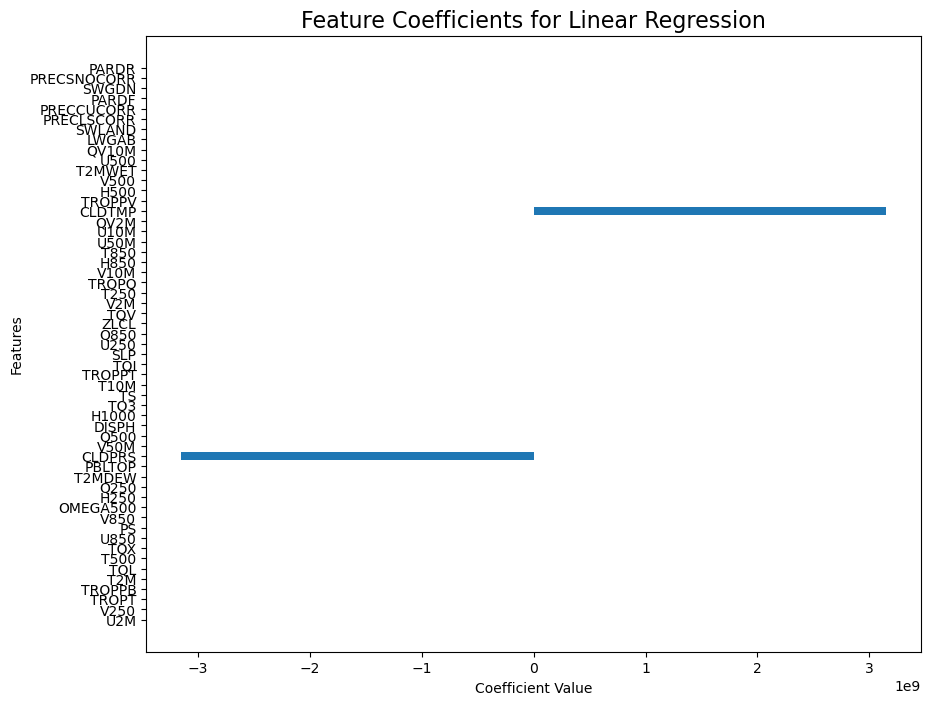

In [ ]:
plt.figure(figsize=(10,8))
plt.barh(width=lr_pipe[1].coef_, y=pvm.columns[:-1])

plt.title('Feature Coefficients for Linear Regression', size=16)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')

## Question 3
What could be the reason why most of the parameters (features) have coefficients close to zero, while some explode to billions? What could this indicate about the model or the data?

> Fill here by double clicking me!

Let's investigate the first point by utilizing ElasticNet with half L1 and L2 losses.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+05, tolerance: 3.357e+02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.278e+02, tolerance: 3.357e+02
  model = cd_fast.enet_coordinate_descent(


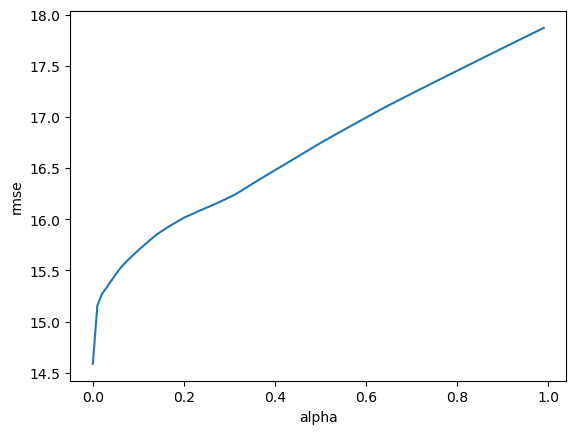

In [ ]:
alphas = np.arange(1,10000,100)/10000

"""
This line generates a range of values for alpha from 0.0001 to 1.0 with a step size of 0.01.
* Alpha controls the strength of the regularization.
* A higher alpha value means stronger regularization, while a lower alpha means less regularization.
"""

rmse = []

for alpha in alphas:
    r_pipe = make_pipeline(StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=0.5))

    """
    Here, we use ElasticNet with a mix of L1 and L2 regularization:
    * alpha controls the overall regularization strength.
    * l1_ratio=0.5 means the loss function will equally balance L1 (Lasso) and L2 (Ridge) penalties.
    An L1 ratio of 0.5 means 50% Lasso and 50% Ridge.
    """

    r_pipe.fit(X_train, y_train)
    y_predr = r_pipe.predict(X_val)

    rmse.append(mean_squared_error(y_predr, y_val)**0.5)

plt.plot(alphas, rmse)
plt.xlabel('alpha')
plt.ylabel('rmse');

Even though the RMSE is lowest when alpha = 0, this corresponds to standard linear regression with no regularization. In this case, neither L1 nor L2 penalties are applied, which eliminates the benefits of regularization and feature selection.

By choosing a small but non-zero value like alpha = 0.1, we retain some regularization.

In [ ]:
r_pipe = make_pipeline(StandardScaler(), ElasticNet(alpha=.1, l1_ratio=.5))

r_pipe.fit(X_train, y_train)

y_predr = r_pipe.predict(X_test)

print(f'RMSE for ElasticNet with alpha={r_pipe[1].alpha}: {mean_squared_error(y_predr, y_test)**0.5:.3f}')

RMSE for ElasticNet with alpha=0.1: 19.406


We can see using any of the other alpha than 0 (equivalent to linear_regression) does not seem optimal. Picking the next best alpha value seems to make a small improvement, but not by much.